In [1]:
def check_gpu():
    import tensorflow as tf
    print("tf.test.is_built_with_cuda()")
    print(tf.test.is_built_with_cuda())
    
    print()
    print("tf.config.list_physical_devices('GPU')")
    print(tf.config.list_physical_devices('GPU'))

    print()
    print("tf.config.experimental.list_physical_devices('GPU')")
    print(tf.config.experimental.list_physical_devices('GPU'))

check_gpu()

tf.test.is_built_with_cuda()
True

tf.config.list_physical_devices('GPU')
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

tf.config.experimental.list_physical_devices('GPU')
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def free_gpu_memory():
    from numba import cuda
    import gc
    try:
        del(model)
    except:
        pass
    try:
        del(history)
    except:
        pass
    try:
        del(tf)
    except:
        pass
    gc.collect()
    cuda.select_device(0)
    cuda.close()
    
free_gpu_memory()

In [3]:
# Load data/train into data/all_train_images, if data/all_train_images doesnt exist
# Load data/test into data/all_test_images, if data/all_test_images doesnt exist

import os

def load_into_all_images(dir_from, dir_to):
    if os.path.exists(dir_to):
        return 
    import shutil
    counter = 0
    os.makedirs(dir_to, exist_ok=True) # Create dir_to folder
    for subdir, dirs, files in os.walk(dir_from):
        for file in files:
            full_path = os.path.join(subdir, file)
            shutil.copy(full_path, dir_to)
            counter = counter + 1
            if counter % 1000 == 0:
                print(counter)
    print(counter)

load_into_all_images("data/train", "data/all_train_images")
load_into_all_images("data/test", "data/all_test_images")


In [4]:
# Load filenames_shuffled (length 14034) and y_labels_one_hot_shuffled from its files
# If files not found, build those 2 variables now and save them to their respective file
# Build test_filenames and test_labels

import numpy as np
from tensorflow.keras.utils import to_categorical

def make_filenames_and_labels(all_folder, folder):
    subdirs, dirs, files = os.walk(all_folder).__next__()
    m = len(files)
    filenames = []
    labels = np.zeros((m, 1))
    filenames_counter = 0
    labels_counter = -1
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            filenames.append(file)
            labels[filenames_counter, 0] = labels_counter
            filenames_counter = filenames_counter + 1
        labels_counter = labels_counter+1
    return filenames, labels
        
def load_shuffle_save():
    from sklearn.utils import shuffle

    filenames, labels = make_filenames_and_labels("data/all_train_images", "data/train")
    
    # One hot vector representation of labels
    y_labels_one_hot = to_categorical(labels)
    
    # Shuffle
    filenames_shuffled, y_labels_one_hot_shuffled = shuffle(filenames, y_labels_one_hot)
    
    np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
    np.save('filenames_shuffled.npy', filenames_shuffled)
    
    return filenames_shuffled, y_labels_one_hot_shuffled

if os.path.exists("y_labels_one_hot_shuffled.npy") and os.path.exists("filenames_shuffled.npy"):
    print("Loading filenames and labels from disk")
    # load shuffled train data (14034)
    y_labels_one_hot_shuffled = np.load("y_labels_one_hot_shuffled.npy")
    filenames_shuffled = np.load("filenames_shuffled.npy")
else:    
    print("Making filenames and labels")
    filenames_shuffled, y_labels_one_hot_shuffled = load_shuffle_save()

test_filenames, test_labels = make_filenames_and_labels("data/all_test_images", "data/test")

Loading filenames and labels from disk


In [5]:
# Split train images (14034) into training set and validation set

from sklearn.model_selection import train_test_split

# Used this line as our filename array is not a numpy array.
filenames_shuffled_numpy = np.array(filenames_shuffled)

X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    filenames_shuffled_numpy, y_labels_one_hot_shuffled, test_size=0.2, random_state=1)

print("y_train.shape", y_train.shape) # (11227, 6)
print("y_val.shape", y_val.shape) # (2807, 6)

y_train.shape (11227, 6)
y_val.shape (2807, 6)


In [6]:
# This image generator generates batch_size images whenever called and also their labels

from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.utils import Sequence

class My_Custom_Generator(Sequence) :
    def __init__(self, folder, image_filenames, labels, batch_size) :
        self.folder = folder
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

    def __getitem__(self, idx) :
        filenames_batch = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        labels_batch = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        imgs = [resize(imread(self.folder + "/" + str(file_name)), (150, 150, 3)) for file_name in filenames_batch]
        imgs = np.array(imgs)/255.0

        return imgs, np.array(labels_batch)

test_generator = My_Custom_Generator("data/all_test_images", test_filenames, test_labels, 64)

In [7]:
# Functions for plotting learning curves and confusion matrix

import matplotlib.pyplot as plt        
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plot_loss_accuracy(history):
    if not isinstance(history, dict):
        history = history.history
        
    num_epochs = len(history["accuracy"])
    x_values = range(1, num_epochs + 1)  # Generate x-axis values starting from 1
        
    # Plot accuracy
    plt.plot(x_values, history['accuracy'], label = "Train acc")
    plt.plot(x_values, history['val_accuracy'], label = "Validation acc")
    plt.title("Learning curve")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.xticks(range(0, num_epochs + 1, 2), range(0, num_epochs + 1, 2))
    plt.show()
    
    # Plot loss function
    plt.plot(x_values, history['loss'], label = "Train loss")
    plt.plot(x_values, history['val_loss'], label = "Validation loss")
    plt.title("Learning curve")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.xticks(range(0, num_epochs + 1, 2), range(0, num_epochs + 1, 2))
    plt.show()
    
def plot_confusion_matrix(model, verbose=1):
    class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street" ]
    preds = model.predict(test_generator, workers=8, verbose=verbose)
    preds_labels = np.argmax(preds, axis=1)
    cm = confusion_matrix(test_labels, preds_labels)
    ax = plt.axes()
    sn.heatmap(cm, annot=True, fmt="d",
               annot_kws={"size": 10}, 
               xticklabels=class_names, 
               yticklabels=class_names, ax = ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

In [8]:
# Util functions for models (saving, loading, evaluating on test set)

from tensorflow.keras.models import load_model
import pickle

def save_model_and_history(model, model_file, history, history_file):
    print("Saving " + model_file + " and history")
    model.save(model_file)
    with open(history_file, 'wb') as hist:
        pickle.dump(history.history, hist)  
    print("Saved " + model_file + " and history")

def load_model_and_history(model_file, model_history_file):
    if not os.path.exists(model_file) or not os.path.exists(model_history_file):
        return None, None
    
    print("Loading model " + model_file + " and history")
    model = load_model(model_file)
    with open(model_history_file, "rb") as hist_file:
        history = pickle.load(hist_file)
    print("Loaded model " + model_file + " and history")
    
    return model, history

def get_test_acc(model, verbose=1):  
    preds = model.predict(test_generator, workers=8, verbose=verbose)
    preds_labels = np.argmax(preds, axis=1)
    cm = confusion_matrix(test_labels, preds_labels) 
    
    sum_diagonal = np.trace(cm)
    acc = sum_diagonal / np.sum(cm)
    return acc

def get_test_accs(model, verbose=1):
    preds = model.predict(test_generator, workers=8, verbose=verbose)
    preds_labels = np.argmax(preds, axis=1)
    cm = confusion_matrix(test_labels, preds_labels) 
    
    accuracies = []
    for i in range(cm.shape[0]):
        tp = cm[i,i]
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - np.sum(cm[:, i]) - np.sum(cm[i, :]) + tp
        fn = np.sum(cm[i, :]) - tp
        acc_class = (tp + tn) / (tp+fp+tn+fn)
        accuracies.append(acc_class)
        
    return accuracies

def evaluate_model(model):
    print("Evaluating on test set...")
    acc = get_test_acc(model, verbose=0)
    print("Test set accuracy: {:.2f}%".format(acc*100))
    accs = get_test_accs(model, verbose=0)
    classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
    for i in range(len(classes)):
        print("Test set accuracy for {}: {:.2f}%".format(classes[i], accs[i]*100))
    return acc

In [9]:
# CNNs

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.nn import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, DenseNet121,  VGG16, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model_name, batch_size, learning_rate=0.001, show_summary=True):
    if model_name == "cnn1":
        model = Sequential([
            Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
            MaxPooling2D(2,2),
            Conv2D(32, (3, 3), activation = 'relu'),
            MaxPooling2D(2,2),
            Flatten(),
            Dense(64, activation=relu),
            Dense(6, activation=softmax)
        ])
    elif model_name == "cnn2":
        model = Sequential()
        model.add(Conv2D(32,(3,3), input_shape=(150, 150,3), activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2),strides=None))
        model.add(Conv2D(64,(3,3), activation='relu' , padding= "same"))
        model.add(MaxPool2D(pool_size=(2,2),strides=None))
        model.add(Conv2D(64,(3,3), activation='relu' , padding= "same"))
        model.add(MaxPool2D(pool_size=(2,2),strides=None))
        model.add(Conv2D(128,(3,3), activation='relu' , padding= "same"))
        model.add(MaxPool2D(pool_size=(2,2),strides=None))
        model.add(Conv2D(128,(3,3), activation='relu' , padding= "same"))
        model.add(MaxPool2D(pool_size=(2,2),strides=None))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.50))
        model.add(Dense(6,activation ='softmax'))
    elif model_name == "resnet":
        # Load the pre-trained ResNet-50 model
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        # Freeze the base model's layers
        base_model.trainable = False
        # Create a new model on top of the base model
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dropout(0.25),
            Dense(6, activation='softmax')
        ])
    elif model_name == "densenet":
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        # Freeze the base model's layers
        base_model.trainable = False
        # Create a new model on top of the base model
        model = Sequential()
        model.add(base_model)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(6, activation='softmax'))  # Assuming 6 scene classes
    elif model_name == "vgg16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        # Freeze the base model's layers
        base_model.trainable = False
        # Create a new model on top of the base model
        model = Sequential()
        model.add(base_model)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(6, activation='softmax'))  # Assuming 6 scene classes
    elif model_name == "inception":
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        # Freeze the base model's layers
        base_model.trainable = False
        # Create a new model on top of the base model
        model = Sequential()
        model.add(base_model)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(6, activation='softmax'))  # Assuming 6 scene classes
    else:
        return None, None # model, history
    
    if show_summary:
        model.summary()
                                 
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    
    my_training_batch_generator = My_Custom_Generator("data/all_train_images", X_train_filenames, y_train, batch_size)
    my_validation_batch_generator = My_Custom_Generator("data/all_train_images", X_val_filenames, y_val, batch_size)
    
    # Stop training if val_accuracy < 0.2 after 3 epochs
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', min_delta=0.0, baseline=0.2)
    
    history = model.fit(
        my_training_batch_generator,
        steps_per_epoch=int(11227 // batch_size),
        epochs=20,
        verbose=1,
        validation_data=my_validation_batch_generator,
        validation_steps=int(2807 // batch_size),
        callbacks=[early_stopping],
        workers=64
    )
        
    return model, history

def train_model_load_save_and_analysis(model_name, batch_size, learning_rate, model_file, show_summary=True):
    print("model_name={0}, batch_size={1}, learning_rate={2}, model_file={3}"
          .format(model_name, batch_size, learning_rate, model_file))
          
    history_file = model_file[0:-3] + "_history"
    model, history = load_model_and_history(model_file, history_file)
    was_model_loaded = model != None and history != None

    if was_model_loaded:
        if show_summary:
            model.summary()
        acc = evaluate_model(model)
    else:
        # Couldn't load model, so train it now and save it
        model, history = train_model(model_name=model_name,
                                     batch_size=batch_size,
                                     learning_rate=learning_rate,
                                     show_summary=show_summary)
        save_model_and_history(model, model_file, history, history_file)
        acc = evaluate_model(model)
        
    if acc < 0.5:
        print("Test accuracy < 0.5, skipping confusion matrix and learning curves")
        return model, history
        
    plot_confusion_matrix(model, verbose=0)
    plot_loss_accuracy(history)  
    
    return model, history
    

In [10]:
# Create the models folder if doesnt exist
if not os.path.exists("models"):
    os.makedirs("models", exist_ok=True)

model_name=cnn1, batch_size=32, learning_rate=0.01, model_file=models/cnn1_32_0.01.h5
Loading model models/cnn1_32_0.01.h5 and history
Loaded model models/cnn1_32_0.01.h5 and history
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flat

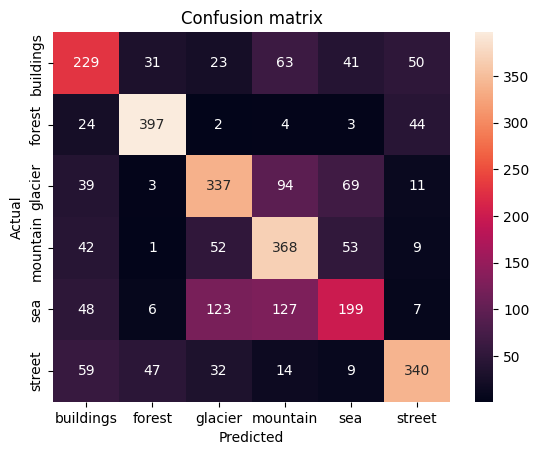

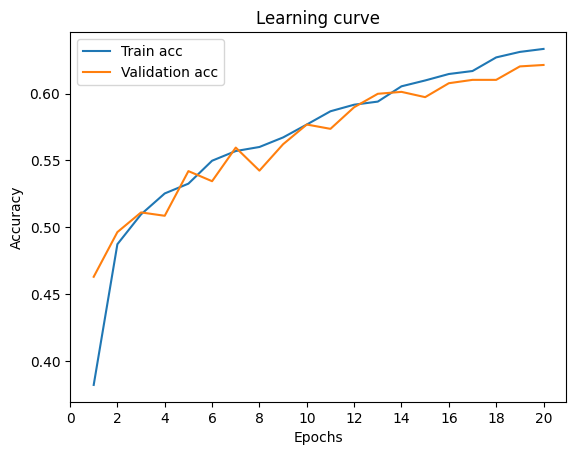

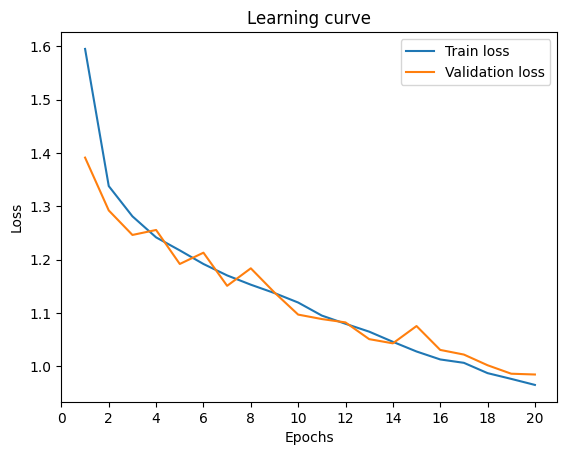

--------//--------
model_name=cnn1, batch_size=128, learning_rate=0.01, model_file=models/cnn1_128_0.01.h5
Loading model models/cnn1_128_0.01.h5 and history
Loaded model models/cnn1_128_0.01.h5 and history
Evaluating on test set...
Test set accuracy: 17.50%
Test set accuracy for buildings: 85.43%
Test set accuracy for forest: 84.20%
Test set accuracy for glacier: 81.57%
Test set accuracy for mountain: 17.50%
Test set accuracy for sea: 83.00%
Test set accuracy for street: 83.30%
Test accuracy < 0.5, skipping confusion matrix and learning curves
--------//--------
model_name=cnn1, batch_size=128, learning_rate=0.001, model_file=models/cnn1_128_0.001.h5
Loading model models/cnn1_128_0.001.h5 and history
Loaded model models/cnn1_128_0.001.h5 and history
Evaluating on test set...
Test set accuracy: 65.80%
Test set accuracy for buildings: 88.37%
Test set accuracy for forest: 94.80%
Test set accuracy for glacier: 85.47%
Test set accuracy for mountain: 88.77%
Test set accuracy for sea: 84.03%


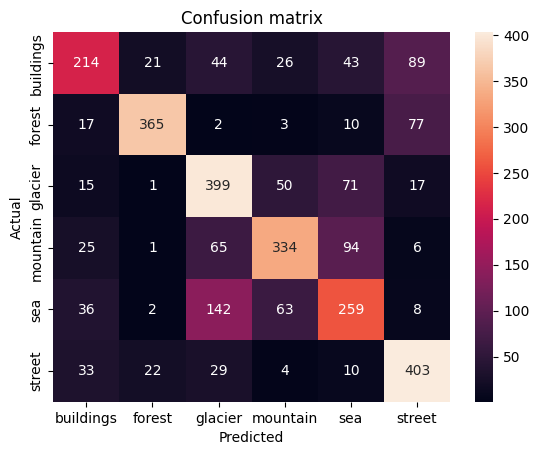

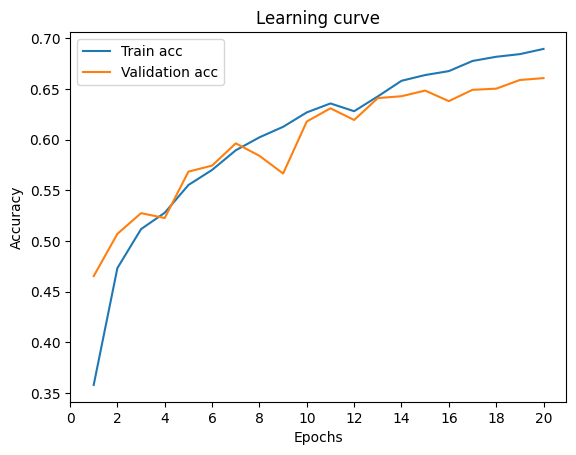

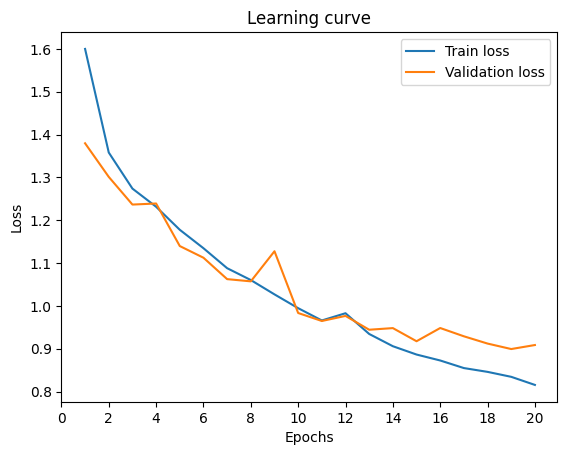

--------//--------
model_name=cnn1, batch_size=128, learning_rate=0.0001, model_file=models/cnn1_128_0.0001.h5
Loading model models/cnn1_128_0.0001.h5 and history
Loaded model models/cnn1_128_0.0001.h5 and history
Evaluating on test set...
Test set accuracy: 59.27%
Test set accuracy for buildings: 83.67%
Test set accuracy for forest: 92.93%
Test set accuracy for glacier: 85.07%
Test set accuracy for mountain: 85.03%
Test set accuracy for sea: 83.00%
Test set accuracy for street: 88.83%


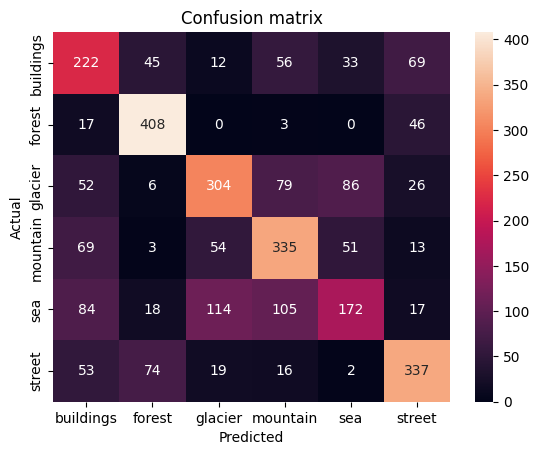

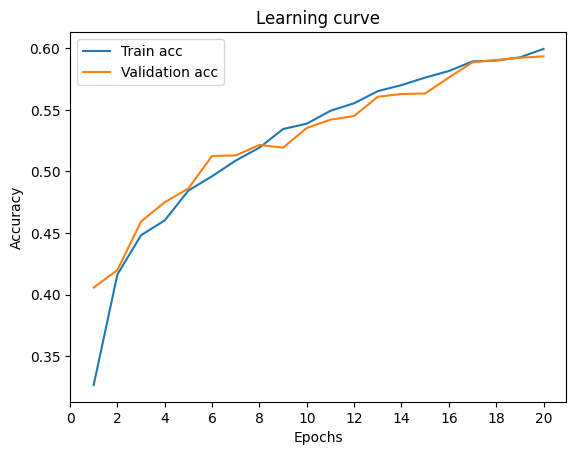

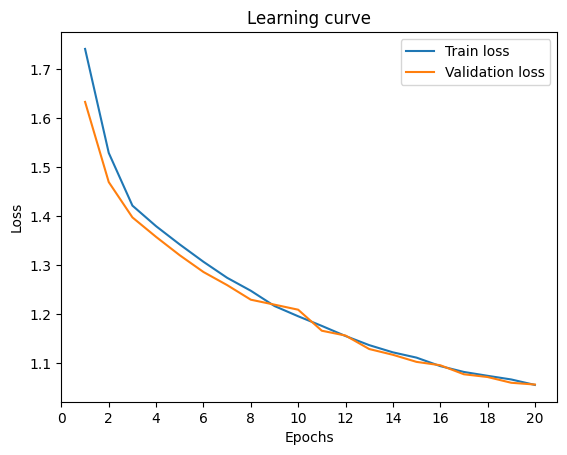

--------//--------
model_name=cnn2, batch_size=32, learning_rate=0.01, model_file=models/cnn2_32_0.01.h5
Loading model models/cnn2_32_0.01.h5 and history
Loaded model models/cnn2_32_0.01.h5 and history
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 74, 74, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                  

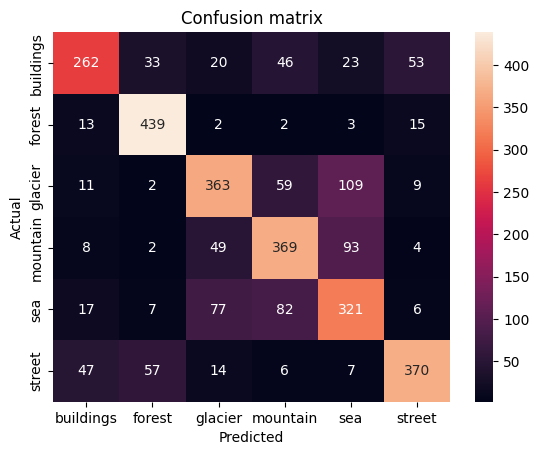

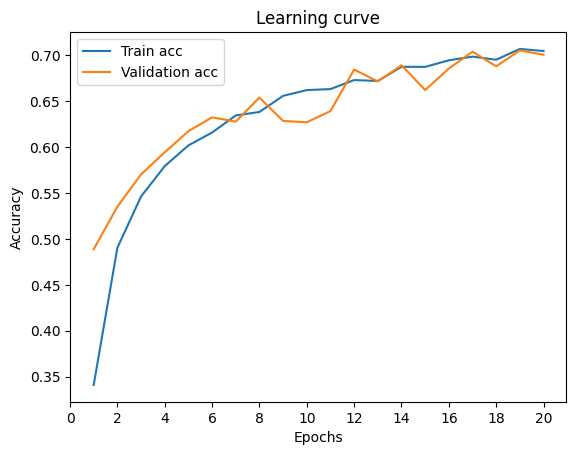

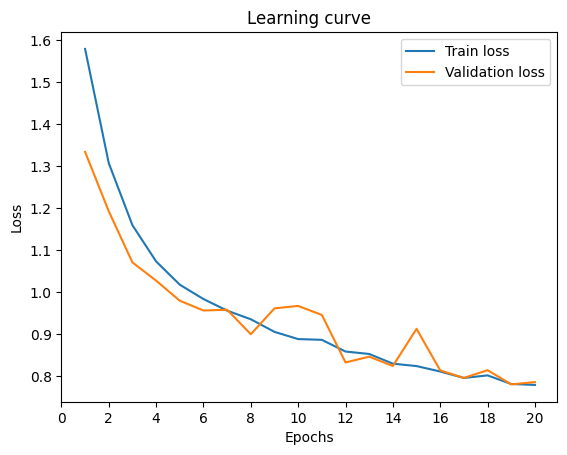

--------//--------
model_name=cnn2, batch_size=128, learning_rate=0.01, model_file=models/cnn2_128_0.01.h5
Loading model models/cnn2_128_0.01.h5 and history
Loaded model models/cnn2_128_0.01.h5 and history
Evaluating on test set...
Test set accuracy: 18.43%
Test set accuracy for buildings: 85.43%
Test set accuracy for forest: 84.20%
Test set accuracy for glacier: 18.43%
Test set accuracy for mountain: 82.50%
Test set accuracy for sea: 83.00%
Test set accuracy for street: 83.30%
Test accuracy < 0.5, skipping confusion matrix and learning curves
--------//--------
model_name=cnn2, batch_size=128, learning_rate=0.001, model_file=models/cnn2_128_0.001.h5
Loading model models/cnn2_128_0.001.h5 and history
Loaded model models/cnn2_128_0.001.h5 and history
Evaluating on test set...
Test set accuracy: 72.97%
Test set accuracy for buildings: 90.87%
Test set accuracy for forest: 96.17%
Test set accuracy for glacier: 88.83%
Test set accuracy for mountain: 90.50%
Test set accuracy for sea: 87.87%


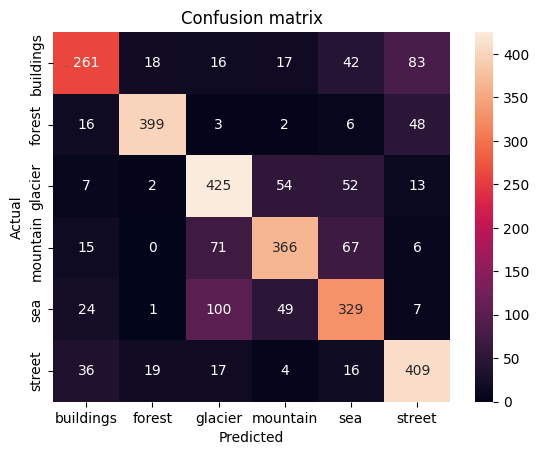

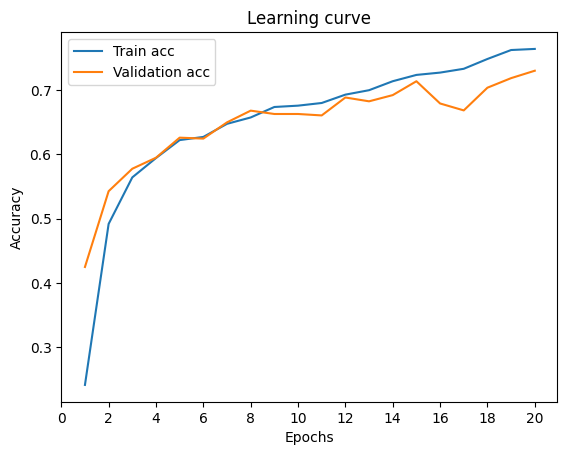

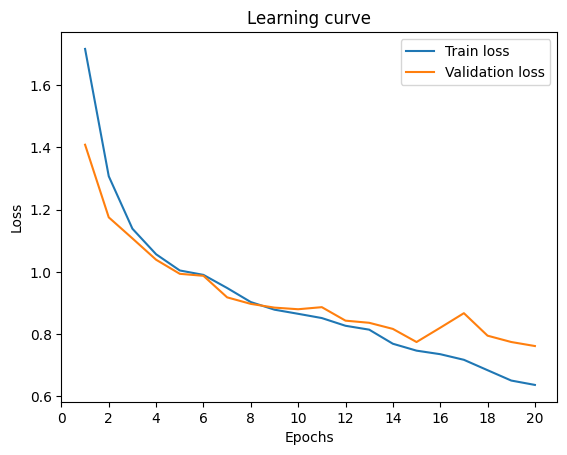

--------//--------
model_name=cnn2, batch_size=128, learning_rate=0.0001, model_file=models/cnn2_128_0.0001.h5
Loading model models/cnn2_128_0.0001.h5 and history
Loaded model models/cnn2_128_0.0001.h5 and history
Evaluating on test set...
Test set accuracy: 65.50%
Test set accuracy for buildings: 86.53%
Test set accuracy for forest: 94.57%
Test set accuracy for glacier: 86.57%
Test set accuracy for mountain: 87.83%
Test set accuracy for sea: 85.37%
Test set accuracy for street: 90.13%


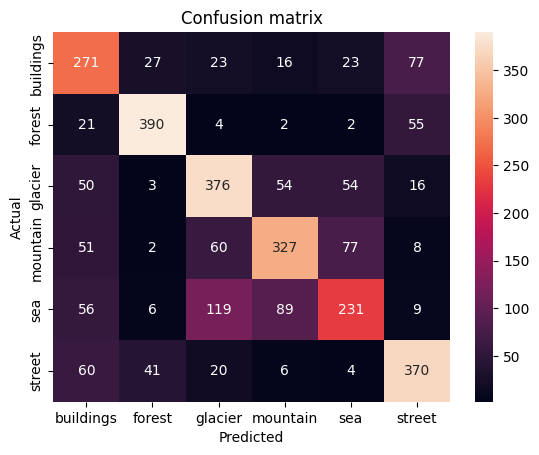

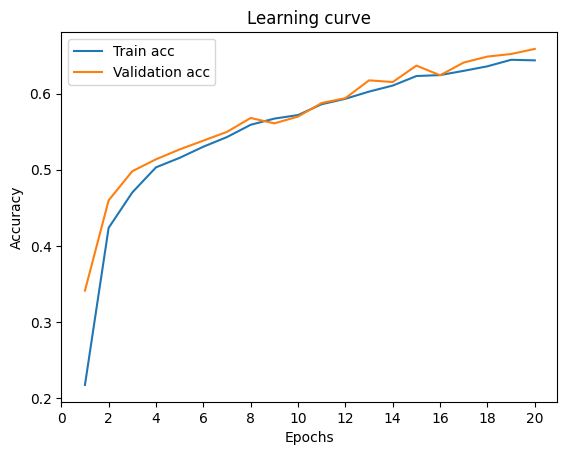

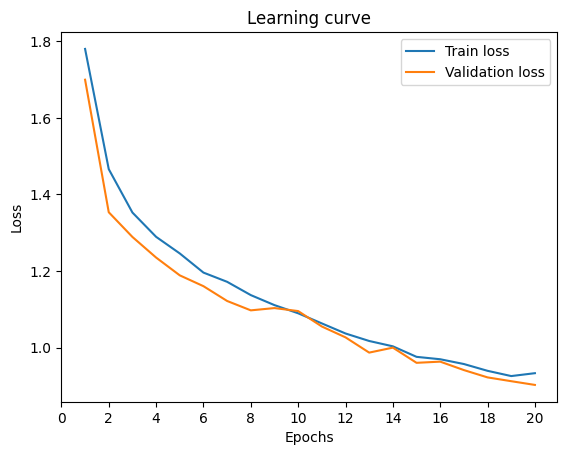

--------//--------
model_name=resnet, batch_size=32, learning_rate=0.01, model_file=models/resnet_32_0.01.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
______________________________________________________________

Epoch 1/20
350/350 [==============================] - 52s 122ms/step - loss: 1.8067 - accuracy: 0.1786 - val_loss: 1.7904 - val_accuracy: 0.1782
Epoch 2/20
350/350 [==============================] - 39s 109ms/step - loss: 1.7920 - accuracy: 0.1745 - val_loss: 1.7910 - val_accuracy: 0.1749
Epoch 3/20
350/350 [==============================] - 39s 111ms/step - loss: 1.7919 - accuracy: 0.1745 - val_loss: 1.7916 - val_accuracy: 0.1782
Saving models/densenet_32_0.01.h5 and history
Saved models/densenet_32_0.01.h5 and history
Evaluating on test set...
Test set accuracy: 17.50%
Test set accuracy for buildings: 85.43%
Test set accuracy for forest: 84.20%
Test set accuracy for glacier: 81.57%
Test set accuracy for mountain: 17.50%
Test set accuracy for sea: 83.00%
Test set accuracy for street: 83.30%
Test accuracy < 0.5, skipping confusion matrix and learning curves
--------//--------
model_name=densenet, batch_size=32, learning_rate=0.001, model_file=models/densenet_32_0.001.h5
Epoch 1/20
350/

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_12  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 14,847,558
Trainable params: 132,870
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
350/350 [================

Trainable params: 526,086
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/20
350/350 [==============================] - 45s 105ms/step - loss: 1.2266 - accuracy: 0.4771 - val_loss: 1.0080 - val_accuracy: 0.5876
Epoch 2/20
350/350 [==============================] - 34s 96ms/step - loss: 0.9951 - accuracy: 0.5934 - val_loss: 0.9496 - val_accuracy: 0.6114
Epoch 3/20
350/350 [==============================] - 34s 94ms/step - loss: 0.9352 - accuracy: 0.6243 - val_loss: 0.9521 - val_accuracy: 0.6185
Epoch 4/20
350/350 [==============================] - 34s 95ms/step - loss: 0.8968 - accuracy: 0.6411 - val_loss: 0.9234 - val_accuracy: 0.6272
Epoch 5/20
350/350 [==============================] - 34s 95ms/step - loss: 0.8681 - accuracy: 0.6583 - val_loss: 0.9267 - val_accuracy: 0.6193
Epoch 6/20
350/350 [==============================] - 34s 94ms/step - loss: 0.8520 - accuracy: 0.6576 - val_loss: 0.8563 - val_accuracy: 0.6663
Epoch 7/20

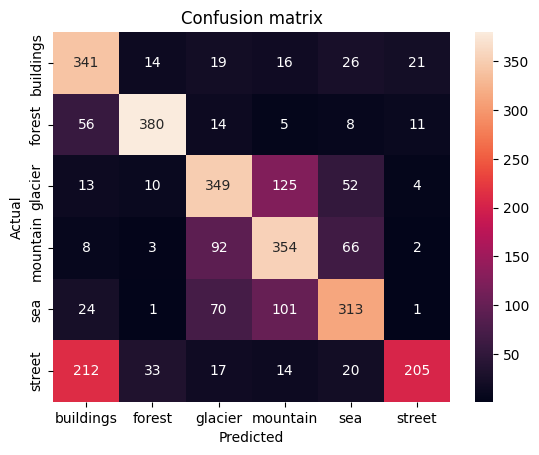

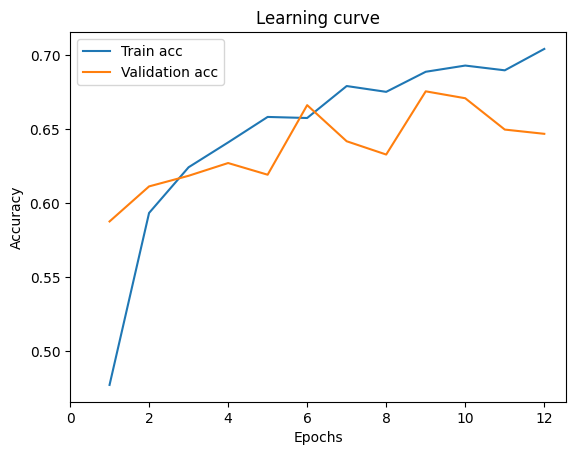

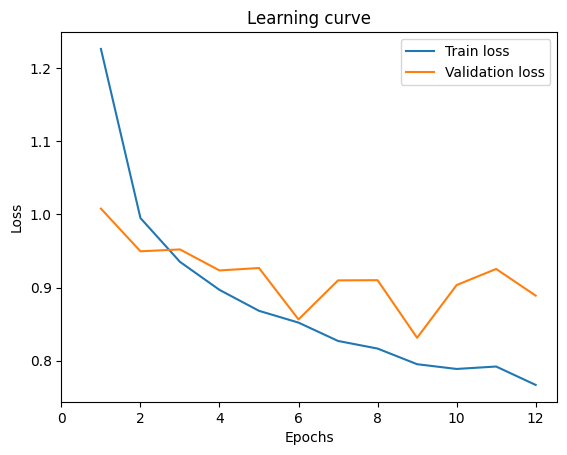

--------//--------
model_name=inception, batch_size=32, learning_rate=0.001, model_file=models/inception_32_0.001.h5
Epoch 1/20
350/350 [==============================] - 41s 100ms/step - loss: 1.3406 - accuracy: 0.4536 - val_loss: 1.1257 - val_accuracy: 0.5675
Epoch 2/20
350/350 [==============================] - 34s 95ms/step - loss: 1.0448 - accuracy: 0.5844 - val_loss: 1.0344 - val_accuracy: 0.5776
Epoch 3/20
350/350 [==============================] - 34s 96ms/step - loss: 0.9664 - accuracy: 0.6201 - val_loss: 0.9738 - val_accuracy: 0.6142
Epoch 4/20
350/350 [==============================] - 34s 96ms/step - loss: 0.9237 - accuracy: 0.6335 - val_loss: 0.9465 - val_accuracy: 0.6250
Epoch 5/20
350/350 [==============================] - 34s 95ms/step - loss: 0.8998 - accuracy: 0.6470 - val_loss: 0.9043 - val_accuracy: 0.6433
Epoch 6/20
350/350 [==============================] - 34s 96ms/step - loss: 0.8726 - accuracy: 0.6580 - val_loss: 0.9356 - val_accuracy: 0.6261
Epoch 7/20
350/350

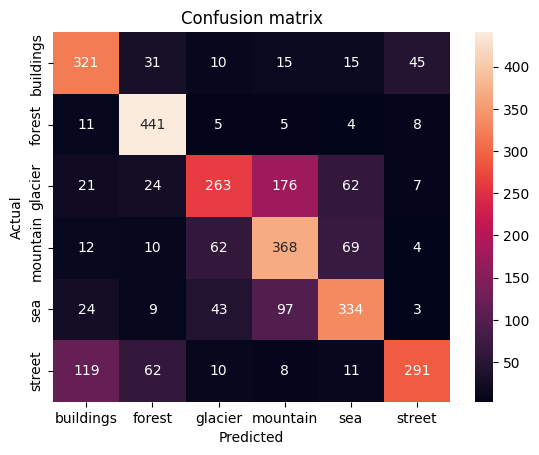

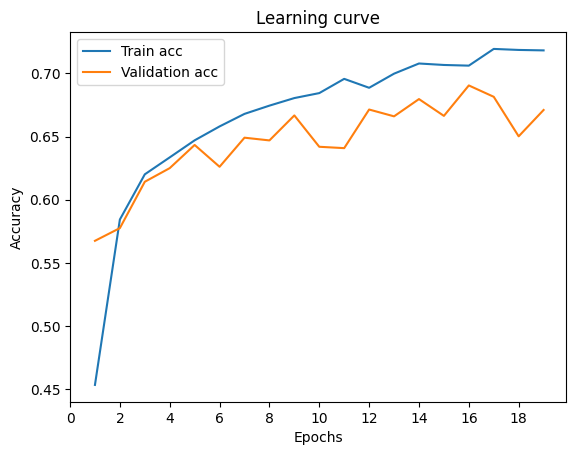

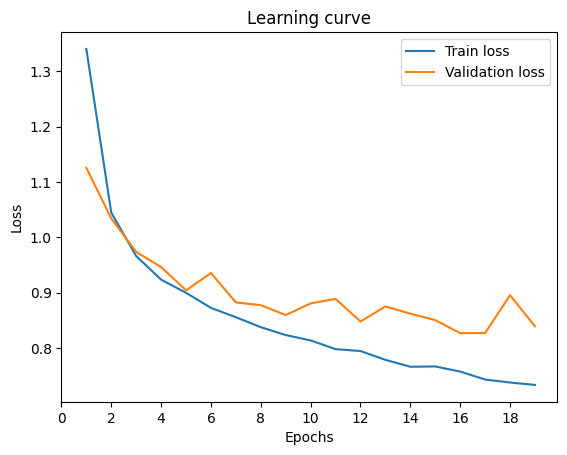

--------//--------
model_name=inception, batch_size=32, learning_rate=0.0001, model_file=models/inception_32_0.0001.h5
Epoch 1/20
350/350 [==============================] - 41s 101ms/step - loss: 1.6709 - accuracy: 0.3700 - val_loss: 1.5626 - val_accuracy: 0.4601
Epoch 2/20
350/350 [==============================] - 35s 97ms/step - loss: 1.4571 - accuracy: 0.4696 - val_loss: 1.3917 - val_accuracy: 0.5205
Epoch 3/20
350/350 [==============================] - 34s 95ms/step - loss: 1.3169 - accuracy: 0.5107 - val_loss: 1.2857 - val_accuracy: 0.5151
Epoch 4/20
350/350 [==============================] - 34s 94ms/step - loss: 1.2286 - accuracy: 0.5418 - val_loss: 1.2186 - val_accuracy: 0.5506
Epoch 5/20
350/350 [==============================] - 34s 96ms/step - loss: 1.1698 - accuracy: 0.5636 - val_loss: 1.1697 - val_accuracy: 0.5438
Epoch 6/20
350/350 [==============================] - 34s 96ms/step - loss: 1.1259 - accuracy: 0.5776 - val_loss: 1.1353 - val_accuracy: 0.5639
Epoch 7/20
350/3

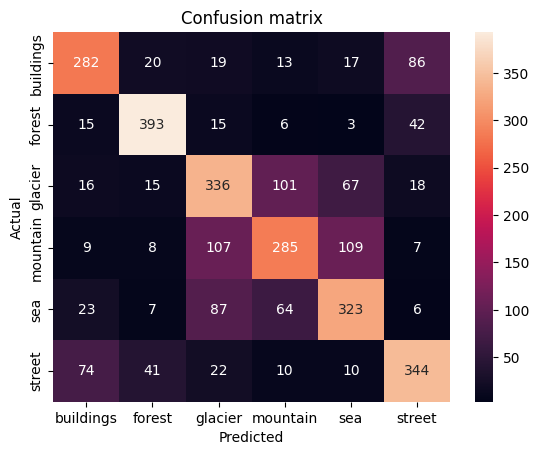

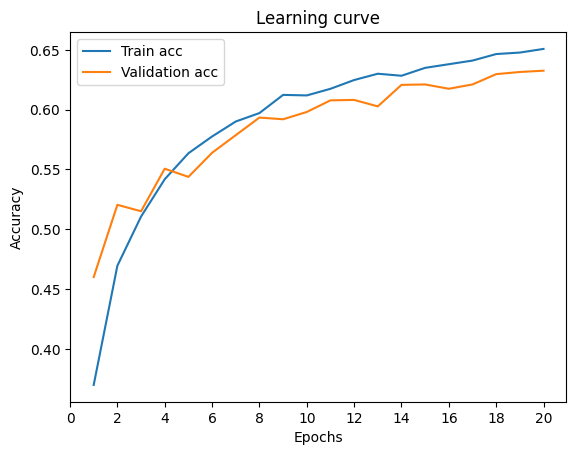

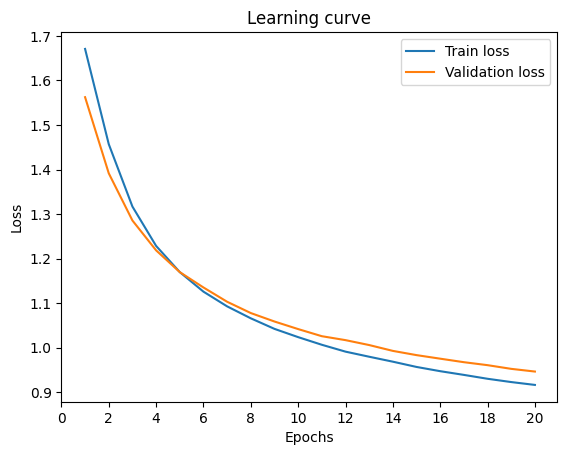

--------//--------
model_name=inception, batch_size=128, learning_rate=0.01, model_file=models/inception_128_0.01.h5
Epoch 1/20
87/87 [==============================] - 51s 473ms/step - loss: 1.3428 - accuracy: 0.4396 - val_loss: 1.1363 - val_accuracy: 0.5134
Epoch 2/20
87/87 [==============================] - 33s 339ms/step - loss: 1.0389 - accuracy: 0.5748 - val_loss: 0.9959 - val_accuracy: 0.5986
Epoch 3/20
87/87 [==============================] - 32s 336ms/step - loss: 0.9602 - accuracy: 0.6146 - val_loss: 0.9890 - val_accuracy: 0.6016
Epoch 4/20
87/87 [==============================] - 32s 337ms/step - loss: 0.9195 - accuracy: 0.6317 - val_loss: 0.9414 - val_accuracy: 0.6343
Epoch 5/20
87/87 [==============================] - 32s 331ms/step - loss: 0.9033 - accuracy: 0.6389 - val_loss: 0.9345 - val_accuracy: 0.6172
Epoch 6/20
87/87 [==============================] - 32s 341ms/step - loss: 0.8636 - accuracy: 0.6583 - val_loss: 0.8979 - val_accuracy: 0.6443
Epoch 7/20
87/87 [=======

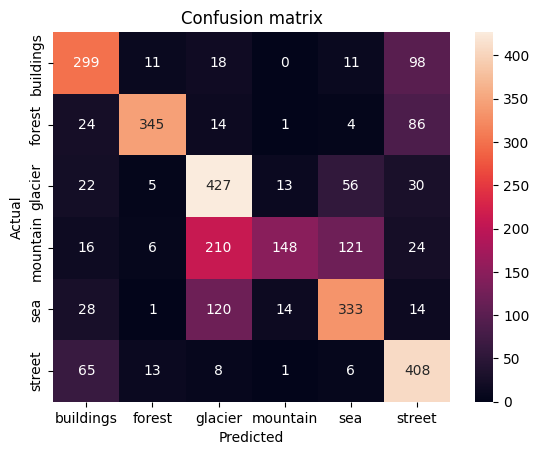

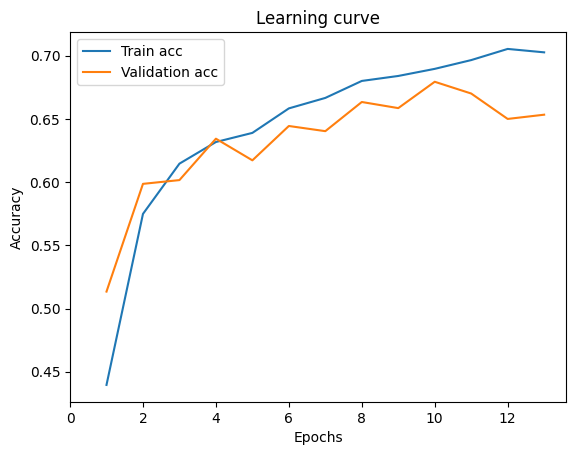

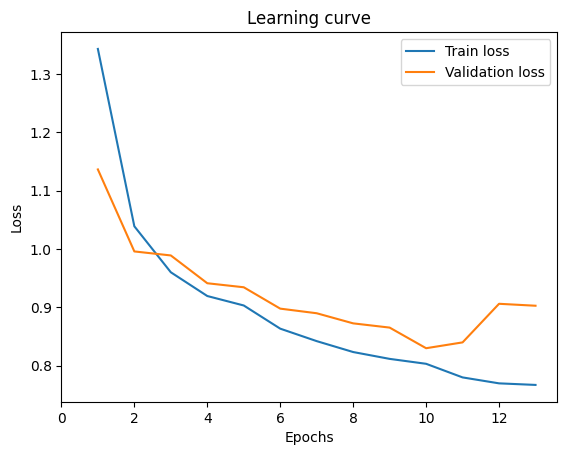

--------//--------
model_name=inception, batch_size=128, learning_rate=0.001, model_file=models/inception_128_0.001.h5
Epoch 1/20
87/87 [==============================] - 39s 358ms/step - loss: 1.4891 - accuracy: 0.4178 - val_loss: 1.2788 - val_accuracy: 0.4978
Epoch 2/20
87/87 [==============================] - 32s 333ms/step - loss: 1.1696 - accuracy: 0.5403 - val_loss: 1.1256 - val_accuracy: 0.5365
Epoch 3/20
87/87 [==============================] - 32s 333ms/step - loss: 1.0671 - accuracy: 0.5805 - val_loss: 1.0475 - val_accuracy: 0.5956
Epoch 4/20
87/87 [==============================] - 32s 335ms/step - loss: 1.0074 - accuracy: 0.6113 - val_loss: 1.0267 - val_accuracy: 0.5934
Epoch 5/20
87/87 [==============================] - 32s 333ms/step - loss: 0.9674 - accuracy: 0.6195 - val_loss: 0.9761 - val_accuracy: 0.6198
Epoch 6/20
87/87 [==============================] - 32s 334ms/step - loss: 0.9342 - accuracy: 0.6373 - val_loss: 0.9640 - val_accuracy: 0.6057
Epoch 7/20
87/87 [=====

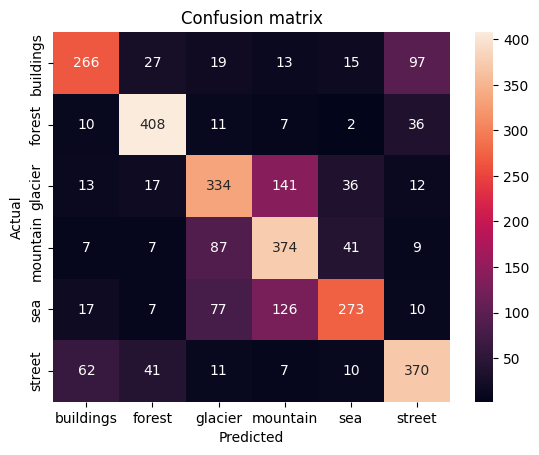

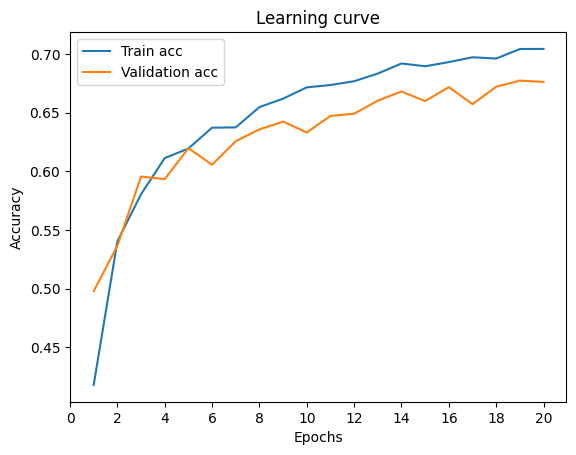

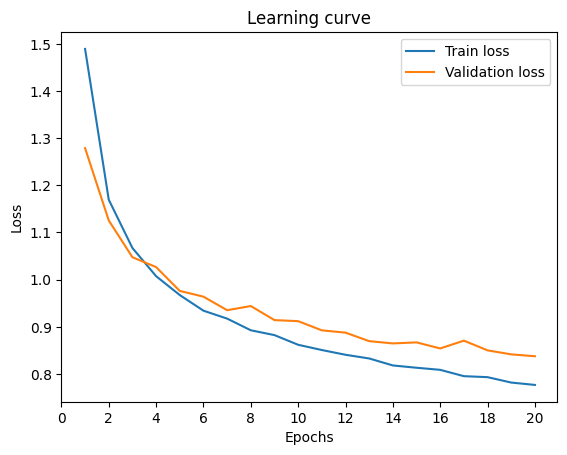

--------//--------
model_name=inception, batch_size=128, learning_rate=0.0001, model_file=models/inception_128_0.0001.h5
Epoch 1/20
87/87 [==============================] - 39s 362ms/step - loss: 1.7466 - accuracy: 0.3522 - val_loss: 1.7055 - val_accuracy: 0.4085
Epoch 2/20
87/87 [==============================] - 32s 333ms/step - loss: 1.6586 - accuracy: 0.4436 - val_loss: 1.6195 - val_accuracy: 0.4081
Epoch 3/20
87/87 [==============================] - 32s 334ms/step - loss: 1.5678 - accuracy: 0.4557 - val_loss: 1.5352 - val_accuracy: 0.4621
Epoch 4/20
87/87 [==============================] - 32s 332ms/step - loss: 1.4839 - accuracy: 0.4768 - val_loss: 1.4573 - val_accuracy: 0.5000
Epoch 5/20
87/87 [==============================] - 32s 330ms/step - loss: 1.4109 - accuracy: 0.5034 - val_loss: 1.3946 - val_accuracy: 0.5030
Epoch 6/20
87/87 [==============================] - 32s 335ms/step - loss: 1.3507 - accuracy: 0.5240 - val_loss: 1.3443 - val_accuracy: 0.5052
Epoch 7/20
87/87 [===

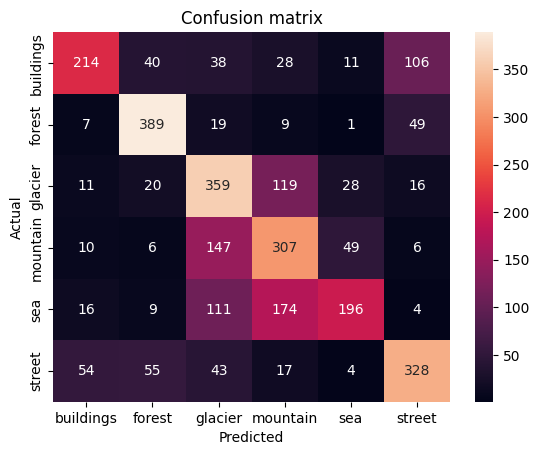

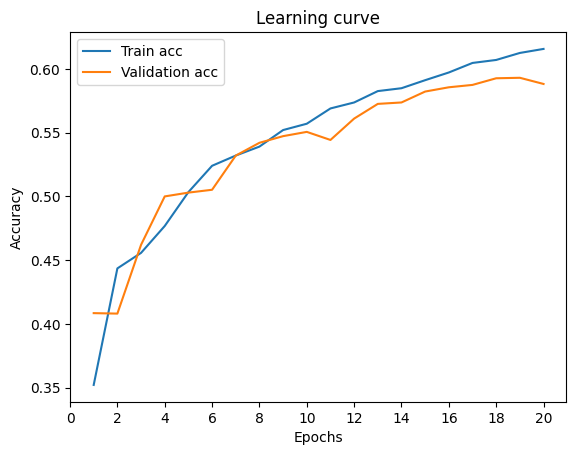

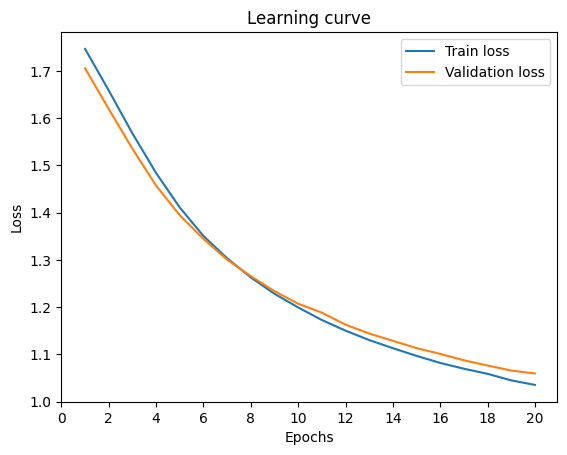

In [11]:
# Grid search, for each CNN

models_names = ["cnn1", "cnn2", "resnet", "densenet", "vgg16", "inception"]
batch_sizes = [32, 128]
learning_rates = [0.01, 0.001, 0.0001]

for model_name in models_names:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            model_file = "models/{0}_{1}_{2}.h5".format(model_name, batch_size, learning_rate)
            show_summary = batch_size == batch_sizes[0] and learning_rate == learning_rates[0]
            train_model_load_save_and_analysis(model_name, 
                                               batch_size, 
                                               learning_rate, 
                                               model_file, 
                                               show_summary=show_summary)  
            printSeparator = model_name != models_names[-1] or batch_size != batch_sizes[-1] or learning_rate != learning_rates[-1]
            if printSeparator:
                print("--------//--------")


In [12]:
free_gpu_memory()

# Results

**CNN 1 - Test set accuracies**

18.43% model_name=cnn1, batch_size=32, learning_rate=0.01, model_file=models/cnn1_32_0.01.h5

17.50% model_name=cnn1, batch_size=32, learning_rate=0.001, model_file=models/cnn1_32_0.001.h5

62.33% model_name=cnn1, batch_size=32, learning_rate=0.0001, model_file=models/cnn1_32_0.0001.h5

17.50% model_name=cnn1, batch_size=128, learning_rate=0.01, model_file=models/cnn1_128_0.01.h5

65.8% model_name=cnn1, batch_size=128, learning_rate=0.001, model_file=models/cnn1_128_0.001.h5

59.27% model_name=cnn1, batch_size=128, learning_rate=0.0001, model_file=models/cnn1_128_0.0001.h5

**CNN 2 - Test set accuracies**

17.50% model_name=cnn2, batch_size=32, learning_rate=0.01, model_file=models/cnn2_32_0.01.h5

17.50% model_name=cnn2, batch_size=32, learning_rate=0.001, model_file=models/cnn2_32_0.001.h5

70.8% model_name=cnn2, batch_size=32, learning_rate=0.0001, model_file=models/cnn2_32_0.0001.h5

18.43% model_name=cnn2, batch_size=128, learning_rate=0.01, model_file=models/cnn2_128_0.01.h5

72.97% model_name=cnn2, batch_size=128, learning_rate=0.001, model_file=models/cnn2_128_0.001.h5

65.50% model_name=cnn2, batch_size=128, learning_rate=0.0001, model_file=models/cnn2_128_0.0001.h5

